
Here we include the neural network model in PyMC3, utilizing Theano tensors to reconstruct the net.

In [83]:
%pylab inline
import pymc3 as pm
import os
os.chdir('/home/oliverphilcox/ChempyMulti/')
from Chempy.parameter import ModelParameters
a=ModelParameters()

Populating the interactive namespace from numpy and matplotlib


/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['e', 'ma']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [95]:
# Load in the neural network weights
model_numpy=np.load("/home/oliverphilcox/ChempyMulti/28element_neural_model.npz")
w_array_0=np.matrix(model_numpy["w_array_0"])
b_array_0=np.matrix(model_numpy["b_array_0"])
w_array_1=np.matrix(model_numpy["w_array_1"])
b_array_1=np.matrix(model_numpy["b_array_1"])
# Load standardization parameters
input_mean=model_numpy.f.input_mean
input_std=model_numpy.f.input_std
output_mean=model_numpy.f.output_mean
output_std=model_numpy.f.output_std

In [96]:
## Load in mock dataset
mock_data=np.load('/mnt/store1/oliverphilcox/ChempyMultiData/MockParams.npz') #dataset
n_stars = len(mock_data.f.abundances)
mu_times = mock_data.f.time_mean #time of birth
sigma_times = mock_data.f.time_error #error on ln(age)

full_abundances = mock_data.f.abundances # chemical element abundances for data
full_errors = mock_data.f.abundance_error # error on abundances

In [97]:
# Filter out correct elements:
all_els = list(a.initial_neural_names)
els = a.initial_neural_names#['Fe', 'He', 'Mg', 'Ne', 'O', 'Si'] # TNG elements but removing C and N for proto-solar corrections

el_indices=np.zeros(len(els),dtype=int)
for e,el in enumerate(els):
    for j in range(len(all_els)):
        if els[e]==str(all_els[j]):
            el_indices[e]=j
            break
        if j==len(all_els)-1:
            print("Failed to find element %s"%el)
obs_abundances = full_abundances[:,el_indices]
obs_errors = full_errors[:,el_indices]

In [98]:
true_Lambda = mock_data.f.params[0,:2]
true_Thetas = mock_data.f.params[:,2:5]
true_Times = mock_data.f.params[:,-1]

In [99]:
# Now standardize dataset
norm_data=(obs_abundances-output_mean)/output_std # use only 6 elements
norm_sd = obs_errors/output_std

In [100]:
data_obs = norm_data.ravel()
data_sd = np.asarray(norm_sd).ravel()

## Check these standardized widths work out right - should be same as std values?

In [101]:
# Define priors
Lambda_prior_mean = a.p0[:2]
Theta_prior_mean = a.p0[2:]
Lambda_prior_width = [0.3,0.3]
Theta_prior_width = [0.3,0.1,0.1]
# Now standardize
std_Lambda_prior_mean = (Lambda_prior_mean-input_mean[:2])/input_std[:2]
std_Lambda_prior_width = (Lambda_prior_width)/input_std[:2]
std_Theta_prior_mean = (Theta_prior_mean-input_mean[2:5])/input_std[2:5]
std_Theta_prior_width = (Theta_prior_width)/input_std[2:5]
std_times_mean = (mu_times-input_mean[-1])/input_std[-1]
std_times_width = sigma_times/input_std[-1]

# Define critical theta edge:
log_SFR_crit = 0.29402
std_log_SFR_crit = (log_SFR_crit-input_mean[3])/input_std[3]

# Define bounds on age to stop predicting out of parameter space:
min_time,max_time = [0.,13.5]
std_min_time,std_max_time=[(time-input_mean[-1])/input_std[-1] for time in [min_time,max_time]]

In [102]:
# Define stacked local priors
Local_prior_mean = np.vstack([np.hstack([std_Theta_prior_mean,std_times_mean[i]]) for i in range(n_stars)])
Local_prior_sigma = np.vstack([np.hstack([std_Theta_prior_width,std_times_width[i]]) for i in range(n_stars)])

In [103]:
import pymc3.math as ma
import theano.tensor as tt



simple_model=pm.Model()
TruncatedNormal = pm.Bound(pm.Normal,lower=std_log_SFR_crit)
AgeNormal = pm.Bound(pm.Normal,lower=std_min_time,upper=std_max_time)

# Share theano variables
w0=tt._shared(w_array_0)
b0=tt._shared(b_array_0)
w1=tt._shared(w_array_1)
b1=tt._shared(b_array_1)
ones_tensor = tt.ones([n_stars,1])

with simple_model:
    # Define priors
    Lambda = pm.Normal('Std-Lambda',mu=std_Lambda_prior_mean,sd=std_Lambda_prior_width,shape=(1,len(std_Lambda_prior_mean)))
    Theta1 = pm.Normal('Std-Theta1',mu=std_Theta_prior_mean[0],sd=std_Theta_prior_width[0],shape=(1,n_stars))
    Theta2 = TruncatedNormal('Std-Theta2',mu=std_Theta_prior_mean[1],sd=std_Theta_prior_width[1],shape=(1,n_stars))
    Theta3 = pm.Normal('Std-Theta3',mu=std_Theta_prior_mean[2],sd=std_Theta_prior_width[2],shape=(1,n_stars))
    Thetas = ma.concatenate([Theta1,Theta2,Theta3]).T
    #Thetas = pm.Normal('Std-Thetas',mu=std_Theta_prior_mean,sd=std_Theta_prior_width,shape=(n_stars,len(std_Theta_prior_mean)))
    Times = AgeNormal('Std-Times',mu=std_times_mean,sd=std_times_width,shape=(1,n_stars))
    
    TruLa = pm.Deterministic('Lambda',Lambda*input_std[:2]+input_mean[:2])
    TruTh = pm.Deterministic('Thetas',Thetas*input_std[2:5]+input_mean[2:5])
    TruTi = pm.Deterministic('Times',Times*input_std[-1]+input_mean[-1])
    
    # Define input parameter matrix
    Lambda_all = ma.matrix_dot(tt.ones([n_stars,1]),Lambda)
    InputVariables = ma.concatenate([Lambda_all,Thetas,Times.T],axis=1)
    
    # Define neural network output
    #Layer 1: (N_el,20) Tanh w0,b0
    #Output Layer: (20,N_el) w1,b1
    layer1 = ma.matrix_dot(InputVariables,w0.T)+ma.matrix_dot(ones_tensor,b0)
    output = ma.matrix_dot(ma.tanh(layer1),w1.T)+ma.matrix_dot(ones_tensor,b1)
    
    network_output = pm.Deterministic("Neural Network",output)
    
    predictions = pm.Deterministic("Predicted-Abundances",output*output_std+output_mean)
    
    # Define likelihood function (unravelling output to make a multivariate gaussian)
    likelihood=pm.Normal('likelihood', mu=output.ravel(), sd=data_sd, observed=data_obs)

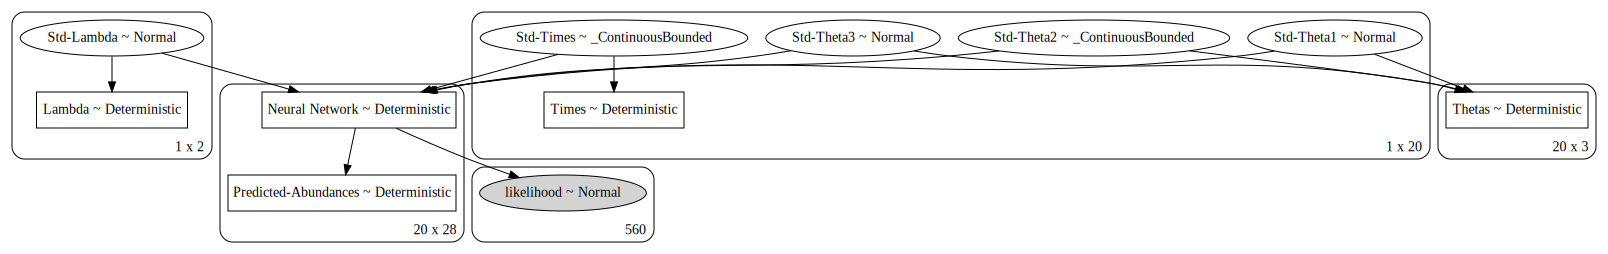

In [105]:
pm.model_to_graphviz(simple_model)

In [106]:
# Now sample
with simple_model:
    samples=pm.sample(draws=1000,chains=4,cores=4,tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Std-Times, Std-Theta3, Std-Theta2, Std-Theta1, Std-Lambda]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:36<00:00, 74.08draws/s] 
/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


In [107]:
pm.summary(samples,varnames=['Lambda']).round(4)

/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Lambda__0_0,-2.6046,0.0115,0.0002,-2.6264,-2.5812,2350.4124,0.9996
Lambda__0_1,-3.0552,0.0144,0.0003,-3.0842,-3.0281,2332.1222,0.9995


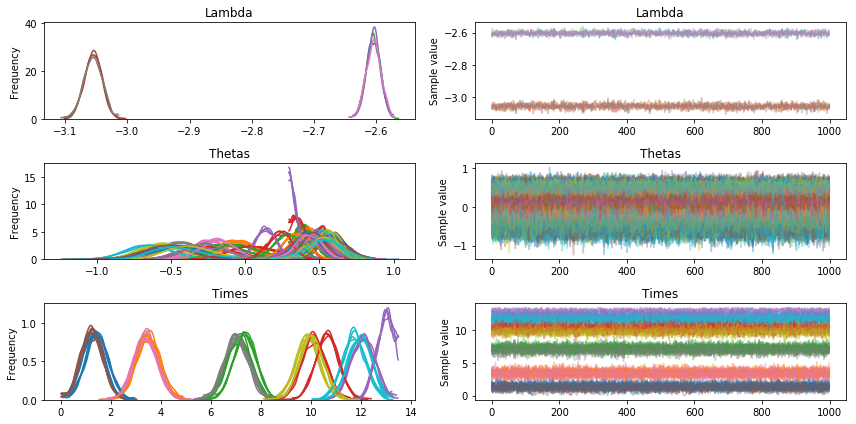

In [108]:
pm.traceplot(samples,varnames=['Lambda','Thetas','Times']);

In [109]:
def construct_output(samples):
    Lambda=samples.get_values('Lambda')[:,0,:]
    Thetas=samples.get_values('Thetas')[:,:,:]
    Times=samples.get_values('Times')[:,0,:]
    return Lambda,Thetas,Times

def single_star_output(samples,star_no):
    Lambda=samples.get_values('Lambda')[:,0,:]
    Thetas=samples.get_values('Thetas')[:,star_no,:]
    Times=samples.get_values('Times')[:,0,star_no].reshape(len(Lambda),1)
    return Lambda,Thetas,Times

In [110]:
Lambda,Thetas,Times=construct_output(samples)

Corner Plot for All Stars

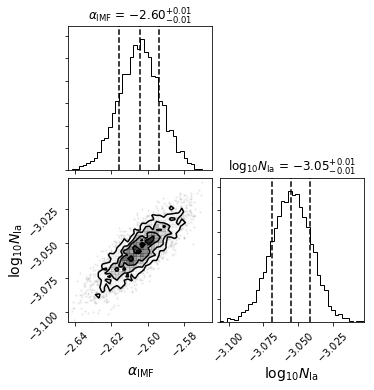

In [111]:
import corner
corner.corner(Lambda,show_titles=True,quantiles=[0.17,0.5,0.83],use_math_text=True,label_kwargs={'fontsize': 14},
              labels=[r'$\alpha_\mathrm{IMF}$',r'$\log_{10}N_\mathrm{Ia}$'],bins=40,truths=true_Lambda);

Corner plot for single star (with $1\sigma$ Gaussian smoothing):

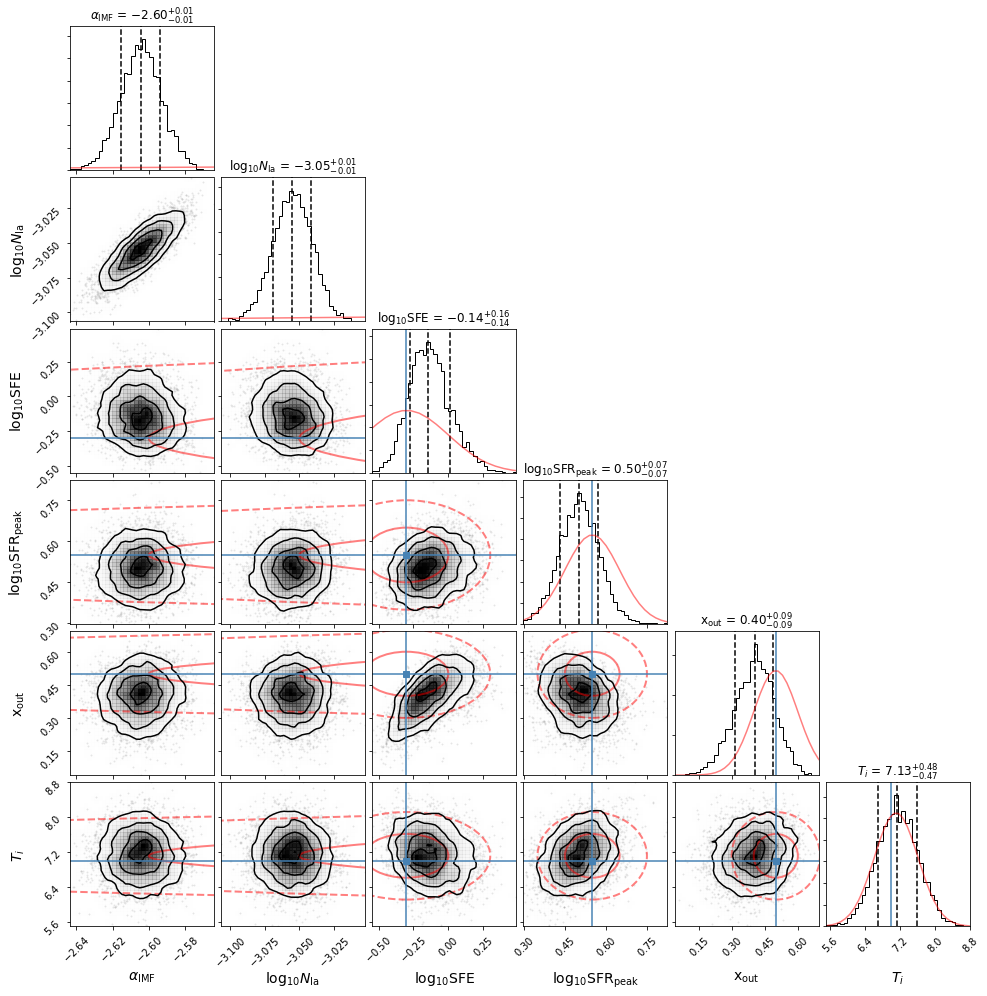

In [112]:
star_index=2
Lambda,Theta1,Times1=single_star_output(samples,star_index)

true_params = np.hstack([true_Lambda,true_Thetas[star_index],true_Times[star_index]])

n_bins=40
names = [r'$\alpha_\mathrm{IMF}$',r'$\log_{10}N_\mathrm{Ia}$',r'$\log_{10}\mathrm{SFE}$',
         r'$\log_{10}\mathrm{SFR}_\mathrm{peak}$',r'$\mathrm{x}_\mathrm{out}$',r'$T_i$']
priors = list(a.p0)+[mu_times[star_index]]
prior_widths = list(np.hstack([Lambda_prior_width,Theta_prior_width]))+[sigma_times[star_index]]
all_dat=np.hstack([Lambda,Theta1,Times1])
figure=corner.corner(all_dat,show_titles=True,quantiles=[0.17,0.5,0.83],truths=true_params,
                     use_math_text=True,label_kwargs={'fontsize': 14},
                     labels=names,bins=n_bins,scale_hist=False,smooth=1.);

integ=np.zeros(len(all_dat[0]))
for i in range(len(all_dat[0])):
    ct,x,=np.histogram(all_dat[:,i],bins=n_bins)
    integ[i]=np.sum(np.diff(x)*ct)

from matplotlib.patches import Ellipse

# Extract the axes
ndim=len(priors)
axes = np.array(figure.axes).reshape((ndim, ndim))

from scipy.stats import norm

for yi in range(ndim):
    xi=yi
    ax=axes[yi,xi]
    xdata=np.linspace(priors[xi]-10*prior_widths[xi],priors[xi]+10*prior_widths[xi],100)
    ax.plot(xdata,integ[yi]*norm.pdf(xdata,loc=priors[xi],scale=prior_widths[xi]),c='r',alpha=0.5)

# Loop over the histograms
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        el=Ellipse([priors[xi],priors[yi]],2*prior_widths[xi],2*prior_widths[yi],
                   facecolor='none',edgecolor='r', lw=2,alpha=0.5)
        el2=Ellipse([priors[xi],priors[yi]],4*prior_widths[xi],4*prior_widths[yi],
                   facecolor='none',edgecolor='r', lw=2,alpha=0.5,ls='--')
        ax.add_artist(el)
        ax.add_artist(el2)

In [113]:
def plotautocorr(samples,max_lags=30,burn_in=100):
    FS=16
    lambda_samples=samples['Lambda'][:,0,:][burn_in:]
    fig,ax=plt.subplots(nrows=2,ncols=1,sharex=True,sharey=True)
    for l,lam in enumerate(lambda_samples.T):
        ax[l].acorr(lam, detrend=plt.mlab.detrend_mean,maxlags=max_lags)
        ax[l].set_ylabel(r"$\Lambda_{%d}$"%(l+1),fontsize=FS)
        ax[l].set_xlim(0, max_lags)

    ax[1].set_xlabel("Lag",fontsize=FS)
    ax[0].set_title(r"$\Lambda$ Autocorrelation Plot using %d burn-in samples"%burn_in,fontsize=FS);   

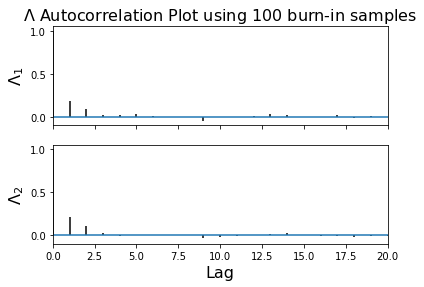

In [114]:
plotautocorr(samples,burn_in=100,max_lags=20);

Plot PPC:

In [115]:
def net_standard_output(standard_in_par):
    """Return neural network output (in standardized form)"""
    l1=np.matmul(w_array_0,np.asmatrix(standard_in_par).T)+b_array_0.T
    standard_out=np.matmul(w_array_1,np.tanh(l1))+b_array_1.T
    return standard_out
def net_output(in_par):
    """Return physics neural network output for destandardized parameters"""
    # Standardize input:
    standard_in=(in_par-input_mean)/input_std
    # Reconstruct network
    standard_out=net_standard_output(standard_in)
    # Destandardize output
    out = np.asarray(standard_out.T)*output_std+output_mean
    return out

In [116]:
all_ppc_abun=[]
for star_index in range(n_stars):
    Lambda,Theta1,Times1=single_star_output(samples,star_index)
    all_par=np.hstack([Lambda,Theta1,Times1])
    ppc_abun = np.asarray([net_output(pp) for pp in all_par])
    all_ppc_abun.append(ppc_abun)

In [117]:
true_p = np.hstack([true_Lambda,true_Thetas[0],true_Times[0]])
pred_ab = net_output(true_p)
true_p2 = np.hstack([true_Lambda,true_Thetas[6],true_Times[5]])
pred_ab2 = net_output(true_p2)

In [118]:
Lambda,Theta1,Times1=single_star_output(samples,0)
pred_p = np.hstack([Lambda.mean(axis=0),Theta1.mean(axis=0),Times1.mean(axis=0)])

In [120]:
pred_stat_ab = net_output(pred_p)
pred_stat_ab

array([[-0.27217144,  0.24636988,  0.37739377,  0.27080955, -0.18128528,
        -0.19833797, -0.02377628, -0.11929743,  0.51200382, -0.69411094,
         0.12744908, -0.08673666,  0.66180331,  0.01770403, -0.23644234,
         0.09317434,  0.41555651, -0.09182227,  0.12146845,  0.23780724,
         0.27471941,  0.02193328,  0.27365367, -0.24749883,  0.25948119,
        -0.3578083 , -0.22424362, -0.30594627]])

In [121]:
pred_ab,pred_ab2

(array([[-3.93370518e-01,  1.46384697e-01,  2.76942588e-01,
          1.59962900e-01, -3.00810458e-01, -2.72925958e-01,
         -1.12186300e-02, -2.31360409e-01,  3.98924907e-01,
         -5.73975548e-01,  1.26465260e-02, -1.99380597e-01,
          5.42139725e-01, -1.26313801e-01, -3.64623062e-01,
          1.54254399e-01,  3.07754469e-01, -2.06261154e-01,
         -2.77628520e-04,  2.42602200e-01,  1.34481368e-01,
         -7.88275907e-02,  1.89658587e-01, -3.69796137e-01,
          1.89308330e-01, -4.22046584e-01, -2.28011210e-01,
         -4.25620104e-01]]),
 array([[-0.41215541,  0.16104153,  0.27362109,  0.18226543, -0.29811497,
         -0.28913104, -0.01735307, -0.27810651,  0.40612809, -0.58541452,
         -0.0275294 , -0.23794918,  0.5644374 , -0.09566138, -0.36885589,
          0.14710194,  0.29842169, -0.23121791, -0.00785254,  0.24187454,
          0.13820144, -0.0934571 ,  0.19800928, -0.38168969,  0.18999388,
         -0.42060109, -0.23930504, -0.45945923]]))

In [122]:
obs_abundances[0]

array([-0.40298046,  0.22383879,  0.28040251,  0.25272583, -0.24331568,
       -0.30733852, -0.02629607, -0.35952619,  0.49999213, -0.66061058,
       -0.10090998, -0.30126248,  0.66061058,  0.64903156, -0.01199269,
       -0.32274141,  0.14265196,  0.33668675, -0.26561501,  0.02411001,
        0.23960255,  0.21240489, -0.08888331,  0.24679028, -0.36526631,
        0.22324143, -0.39905435, -0.26229701])

In [123]:
pred_ab

array([[-3.93370518e-01,  1.46384697e-01,  2.76942588e-01,
         1.59962900e-01, -3.00810458e-01, -2.72925958e-01,
        -1.12186300e-02, -2.31360409e-01,  3.98924907e-01,
        -5.73975548e-01,  1.26465260e-02, -1.99380597e-01,
         5.42139725e-01, -1.26313801e-01, -3.64623062e-01,
         1.54254399e-01,  3.07754469e-01, -2.06261154e-01,
        -2.77628520e-04,  2.42602200e-01,  1.34481368e-01,
        -7.88275907e-02,  1.89658587e-01, -3.69796137e-01,
         1.89308330e-01, -4.22046584e-01, -2.28011210e-01,
        -4.25620104e-01]])

No handles with labels found to put in legend.


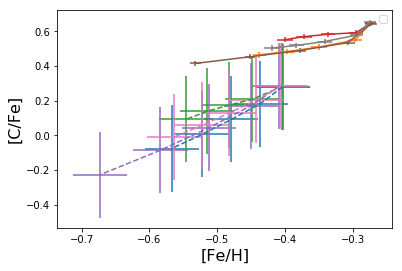

In [124]:
ind1=2
len_T = len(np.unique(true_Times))
for index in range(n_stars//len_T):
    obs_Fe_H,obs_Mg_Fe,obs_Fe_H_err,obs_Mg_Fe_err=[[] for _ in range(4)]
    Fe_H,Mg_Fe,Fe_H_err,Mg_Fe_err=[[] for _ in range(4)]
    for jndex in range(len_T):
        star_index = index*len_T+jndex
        this_ppc_mean = np.mean(all_ppc_abun[star_index][:,0,:],axis=0)
        this_ppc_std = np.std(all_ppc_abun[star_index][:,0,:],axis=0)
        obs_Fe_H.append(obs_abundances[star_index,0])
        obs_Mg_Fe.append(obs_abundances[star_index,ind1])
        Fe_H.append(this_ppc_mean[0])
        Mg_Fe.append(this_ppc_mean[ind1]-this_ppc_mean[0])
        Fe_H_err.append(this_ppc_std[0])
        Mg_Fe_err.append(np.sqrt(this_ppc_std[0]**2.+this_ppc_std[ind1]**2.))
        obs_Fe_H_err.append(obs_errors[star_index,0])
        obs_Mg_Fe_err.append(np.sqrt(obs_errors[star_index,0]**2.+obs_errors[star_index,ind1]))
    plt.errorbar(obs_Fe_H,obs_Mg_Fe,xerr=obs_Fe_H_err,yerr=obs_Mg_Fe_err,ls='--')
    plt.errorbar(Fe_H,Mg_Fe,xerr=Fe_H_err,yerr=Mg_Fe_err,ls='-')
plt.legend();plt.ylabel('[%s/Fe]'%els[ind1],fontsize=16);plt.xlabel('[Fe/H]',fontsize=16);

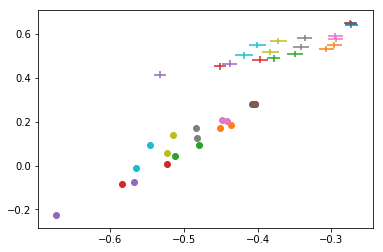

In [125]:
for star_index in range(n_stars):
    this_ppc_mean = np.mean(all_ppc_abun[star_index][:,0,:],axis=0)
    this_ppc_std = np.std(all_ppc_abun[star_index][:,0,:],axis=0)
    obs_Fe_H = obs_abundances[star_index,0]
    obs_Mg_Fe = obs_abundances[star_index,2]
    Fe_H = this_ppc_mean[0]
    Mg_Fe = this_ppc_mean[2]-this_ppc_mean[0]
    err_Fe_H = this_ppc_std[0]
    err_Mg_Fe = np.sqrt(this_ppc_std[0]**2.+this_ppc_std[2]**2.)
    plt.errorbar(Fe_H,Mg_Fe,xerr=err_Fe_H,yerr=err_Mg_Fe)
    plt.scatter(obs_Fe_H,obs_Mg_Fe)

In [172]:
mean(all_ppc_abun[star_index][:,0,:])

-0.13554205532412766